In [1]:
print("Hello")

Hello


In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

# Calibrate Camera and Undistort

In [3]:

def calibrate_camera(paths):
    
    nx = 9
    ny = 6

    objpoints = []
    imgpoints = []

    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for path in paths:
        img = cv2.imread('camera_cal/' + path)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [4]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [5]:
chessboard_imgs = os.listdir('camera_cal')
mtx, dist = calibrate_camera(chessboard_imgs)

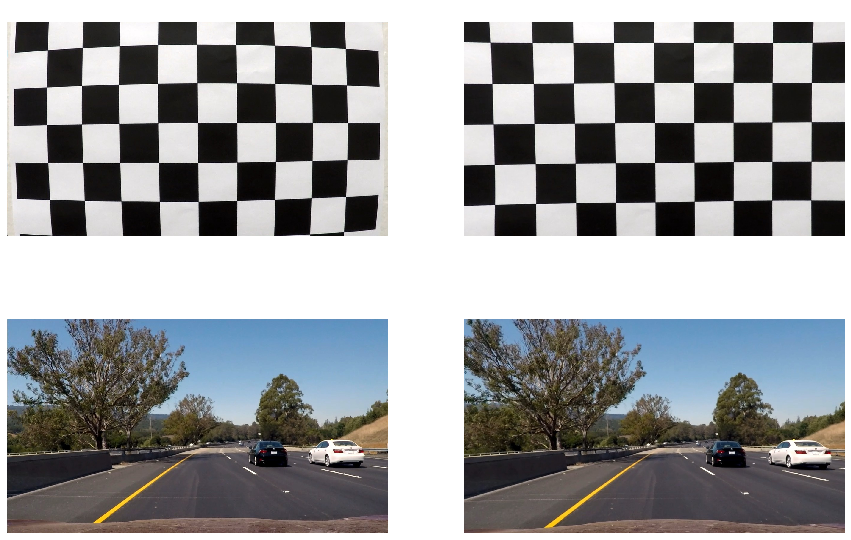

In [6]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
path = 'test_images/test6.jpg'
img = mpimg.imread(path)
ca_path = 'camera_cal/calibration1.jpg'
ca_img = mpimg.imread(ca_path)

undist_ca = undistort(ca_img, mtx, dist)
undist = undistort(img, mtx, dist)
ax1.imshow(ca_img)
ax1.set_title("Original Image", color='w')
ax1.axis('off')
ax2.imshow(undist_ca)
ax2.set_title("Undist Image", color='w')
ax2.axis('off')
ax3.imshow(img)
ax3.axis('off')
ax4.imshow(undist)
ax4.axis('off')
plt.show()

# Gaussian Blur to smooth out the image

In [7]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [8]:
blured = gaussian_blur(undist, 9)

# Color and Gradient

In [9]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

In [10]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

In [11]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

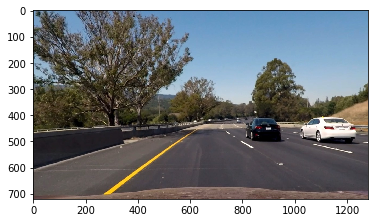

In [50]:
path = 'test_images/test6.jpg'
img = mpimg.imread(path)
undist = undistort(img, mtx, dist)
#undist = gaussian_blur(undist, 9)
plt.imshow(undist)

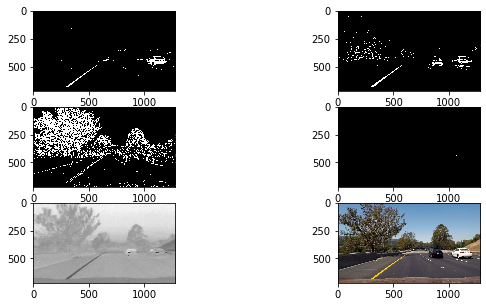

In [51]:
gradx = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=200)
grady = abs_sobel_thresh(img, orient='y', thresh_min=10, thresh_max=200)
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(140, 200))
dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(np.pi/6, np.pi/2))

combined = np.zeros_like(dir_binary)
binary_comb = ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))
combined[binary_comb] = 1

color_threshold = 200
r_channel = img[:, :, 0]
g_channel = img[:, :, 0]
r_binary = np.zeros_like(r_channel)
r_binary[(r_channel > color_threshold) & (g_channel > color_threshold)] = 1

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:, :, 2]
l_channel = hls[:, :, 1]
b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
# color_combined = np.zeros_like(s)

s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

b_thresh_min = 200
b_thresh_max = 250
b_binary = np.zeros_like(b_channel)
b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

l_thresh_min = 255
l_thresh_max = 255
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 5))
ax1.imshow(r_binary, cmap='gray')
ax2.imshow(s_binary, cmap='gray')
ax3.imshow(combined, cmap='gray')
ax4.imshow(l_binary, cmap='gray')
ax5.imshow(b_channel, cmap='gray')
ax6.imshow(img, cmap='gray')

In [52]:
def color_gradient(img):
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=200)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=12, thresh_max=200)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(140, 200))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(np.pi/6, np.pi/2))
    
    combined = np.zeros_like(dir_binary)
    binary_comb = ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))
    combined[binary_comb] = 1
    
    color_threshold = 200
    r_channel = img[:, :, 0]
    g_channel = img[:, :, 0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > color_threshold) & (g_channel > color_threshold)] = 1
     
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
    color_combined = np.zeros_like(s_channel)
    
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 200
    b_thresh_max = 250
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 255
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    color_combined[(combined == 1) | (r_binary == 1) | (b_channel == 1)] = 1
    return color_combined

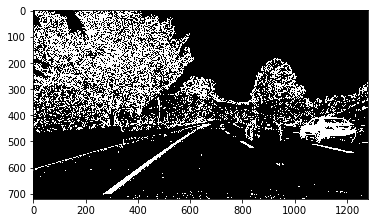

In [53]:
combined = color_gradient(undist)
plt.imshow(combined, cmap='gray')

In [54]:
print(img.shape)

(720, 1280, 3)


In [55]:
def warp(img, src_pos, dst_pos):
    src = src_pos
    dis = dst_pos
    
    M = cv2.getPerspectiveTransform(src, dis)
    Minv = cv2.getPerspectiveTransform(dis, src)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

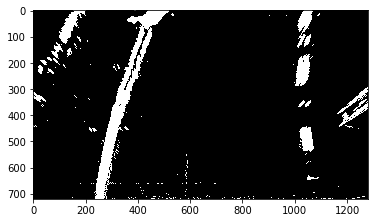

In [56]:

src = np.float32([[280,  700], [600,  450],  [725,  450], [1125, 700]])
dis = np.float32([[250,  720], [250,    0],  [1065,   0], [1065, 720]])
warped_img, M, Minv = warp(undist, src, dis)
combined_warp = color_gradient(warped_img)
plt.imshow(combined_warp, cmap='gray')

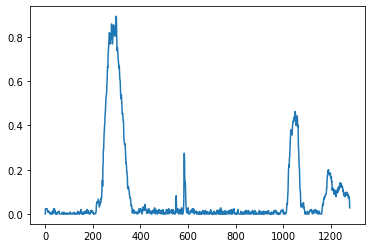

In [57]:
hist_img = combined_warp/255
def hist(img):
    bottom_half = img[img.shape[0]//2:, :]
    
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(hist_img)

#plt.imshow(combined_warp, cmap='gray')
plt.plot(histogram)

In [58]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
    
        good_right_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xright_low) & 
                          (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line')
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
#     plt.plot(left_fitx, ploty, color='y')
#     plt.plot(right_fitx, ploty, color='y')
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img



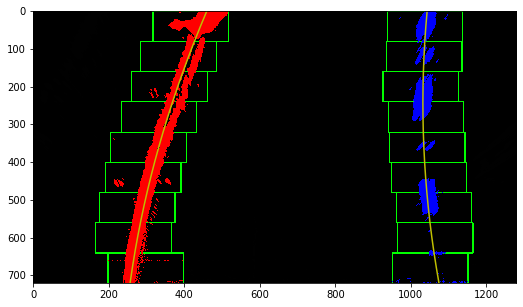

In [59]:
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(combined_warp)
f = plt.figure(figsize=(10, 5))
plt.plot(left_fitx, ploty, color='y')
plt.plot(right_fitx, ploty, color='y')
plt.imshow(out_img)
plt.show()

In [60]:
def search_around_poly(binary_warped):
    left_fit, right_fit, left_fitx, right_fitx, ploty, out_img= fit_polynomial(binary_warped)
    
    margin = 100
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                     (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                     (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[left_lane_inds]
    righty = nonzeroy[left_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.plot(left_fitx, ploty, color='y')
    plt.plot(right_fitx, ploty, color='y')
    
    return leftx, rightx, result


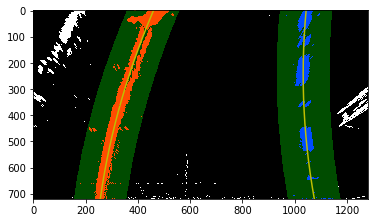

In [61]:
leftx, rightx, result = search_around_poly(combined_warp)
plt.imshow(result)

In [62]:
def curvature_radius(binary_warped, left_fitx, right_fitx):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/800
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fitx[::-1]
    right_fitx = right_fitx[::-1]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2)/np.absolute(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2)/np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = curvature_radius(combined_warp, left_fitx, right_fitx)

In [63]:
print(left_curverad, 'm', right_curverad, 'm')

951.9456777890995 m 998.9805210202692 m


In [64]:
def car_offset(left_fitx, right_fitx, binary_warped):
    xm_perpix = 3.7/800
    mid_imgx = binary_warped.shape[1]//2
    car_pos = (left_fitx[-1] + right_fitx[-1])/2
    offsetx = (mid_imgx - car_pos) * xm_perpix
    
    return offsetx

In [65]:
offsetx = car_offset(left_fitx, right_fitx, combined_warp)

In [66]:
print('Car offset from center:', offsetx)

Car offset from center: -0.11836030770019124


In [67]:
def draw_trapazoid(img, warped_img, left_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
    

In [68]:
img_lane = draw_trapazoid(img, warped_img, left_fitx, right_fitx, ploty, Minv)
plt.imshow(img_lane)

error: OpenCV(4.1.0) ../modules/core/src/array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'scalarToRawData'
